<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/compromise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Picking the best option
## Multiobjective compromising

Often, decision making involves two or more possibly contradictory criteria to simultaneously optimize. Picking the best in the sense of one criterion tends to imply a sacrifice in another. In this session, we will explore how to deal with these types of situations.

As an example scenario, let's assume we have been looking to buy a used car. We have a bunch of options for which we have quantified the criteria we wish to take into account.

In [64]:
def normalize(d): # a trick we need later to make numerical sense of things
  low = min(d)
  high = max(d)
  span = high - low
  return [ (value - low) / span for value in d]

In [78]:
n = 200 # how many alternatives to generate

import pandas as pd
from random import randint

# assign a price to each car in CAD
p = [ randint(3500, 35000) for car in range(n) ]
price = pd.Series(p, name = 'Price')
nprice = pd.Series(normalize(p), name = 'NPrice')

# assign a milage
m = [ randint(200, 150000) for car in range(n) ]
milage = pd.Series(m, name = 'Milage')
nmilage = pd.Series(normalize(m), name = 'NMilage')

# assign how many miles per gallon the car runs on average
m2 = [ randint(30, 70) for car in range(n) ]
mpg = pd.Series(m2, name = 'FuelEfficiency')
nmpg = pd.Series(normalize(m2), name = 'NFuelEfficiency')

# assign carbon dioxide emissions per gallon in grams
e = [ randint(8000, 9000) for car in range(n) ]
co2 = pd.Series(e, name = 'Emissions')
nco2 = pd.Series(normalize(e), name = 'NEmissions')

# subjective coolness on scale from 1 (lame) to 5 (neat)
c = [ randint(1, 5) for car in range(n) ]
cool = pd.Series(c, name = 'Rating')
ncool = pd.Series(normalize(c), name = 'NRating')

We can combine all this information into a **data frame**, a spreadsheet of sorts. To do so, we concatenate the lists as columns. We can look at the "head" (the first few rows) of the result to see what we have created.

In [79]:
attributes = [ price, milage, mpg, co2, cool, nprice, nmilage, nmpg, nco2, ncool ]
cars = pd.concat(attributes, axis = 1)
cars.head()

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
0,20230,98244,43,8984,2,0.525401,0.659287,0.325,0.984,0.25
1,10396,105371,49,8396,4,0.209408,0.707745,0.475,0.396,0.75
2,10678,147702,42,8760,1,0.218470,0.995560,0.300,0.760,0.00
3,8759,46409,31,8673,4,0.156807,0.306853,0.025,0.673,0.75
4,26446,18846,65,8215,5,0.725137,0.119448,0.875,0.215,1.00


We can now easily ask questions like "which car is the cheapest?".

In [80]:
cheapest = cars['Price'].idxmin() # what is the index (row label) of the row that has the minimum value of column Price
print(cheapest) # the index
cars.loc[cheapest] # the data on the row corresponding to that index

76


Price               3879.000000
Milage             71865.000000
FuelEfficiency        63.000000
Emissions           8100.000000
Rating                 5.000000
NPrice                 0.000000
NMilage                0.479932
NFuelEfficiency        0.825000
NEmissions             0.100000
NRating                1.000000
Name: 76, dtype: float64

Or "which ones are the five-star rated alternatives in terms of how cool I think they are?".

In [81]:
cars['Rating'] == 5

0      False
1      False
2      False
3      False
4       True
       ...  
195    False
196    False
197    False
198     True
199     True
Name: Rating, Length: 200, dtype: bool

In [82]:
cars.loc[ cars['Rating'] == 5 ]

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
4,26446,18846,65,8215,5,0.725137,0.119448,0.875,0.215,1.0
5,18627,82126,38,8381,5,0.473892,0.549698,0.200,0.381,1.0
6,28632,46113,55,8299,5,0.795379,0.304840,0.625,0.299,1.0
11,28570,24362,53,8079,5,0.793387,0.156952,0.575,0.079,1.0
18,21762,21169,48,8622,5,0.574628,0.135242,0.450,0.622,1.0
24,26753,135125,66,8847,5,0.735002,0.910047,0.900,0.847,1.0
25,13395,14656,65,8983,5,0.305774,0.090959,0.875,0.983,1.0
27,33467,95495,57,8029,5,0.950741,0.640596,0.675,0.029,1.0
29,20338,21463,61,8674,5,0.528871,0.137241,0.775,0.674,1.0
45,28939,60588,30,8776,5,0.805244,0.403258,0.000,0.776,1.0


Which ones are both cool and cost less than 10k?

In [83]:
cars[ (cars['Rating'] == 5) & (cars['Price'] < 10000) ]

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
76,3879,71865,63,8100,5,0.000000,0.479932,0.825,0.100,1.0
107,9322,22100,54,8689,5,0.174898,0.141572,0.600,0.689,1.0
132,6034,77147,45,8063,5,0.069246,0.515845,0.375,0.063,1.0
133,8517,79193,50,8910,5,0.149031,0.529757,0.500,0.910,1.0
158,5399,75717,63,8464,5,0.048842,0.506123,0.825,0.464,1.0
177,7570,127024,48,8200,5,0.118602,0.854967,0.450,0.200,1.0
182,9272,115645,53,8556,5,0.173291,0.777599,0.575,0.556,1.0


Our next difficulty lies in that we want to **maximize** some of these criteria, while we wish to **minimize** others. It is easier to automate the processing if all criteria "work the same way".

Luckily, math solves this. If we multiply a function by -1, it's hills become its valleys and vice versa. To understand this better, let's improvise a function that has nothing to do with anything, just to see what happens when we multiply it by -1.

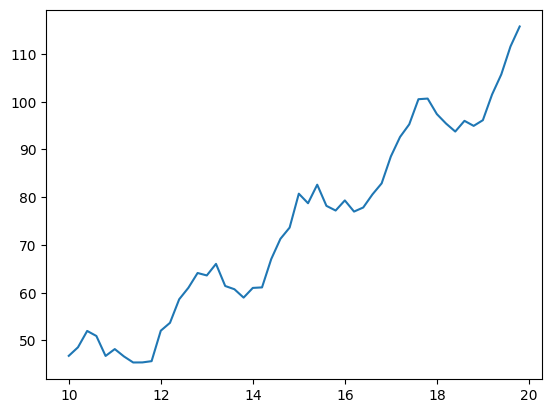

In [39]:
import numpy as np
x = np.arange(10, 20, 0.2)
r = np.random.rand(x.size)
y = 6.5 * np.sin(34 * x) + 1.8 * x**1.4 - 0.6 * x + 5 * r
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.show()

Now, we keep the same x but use -y instead.

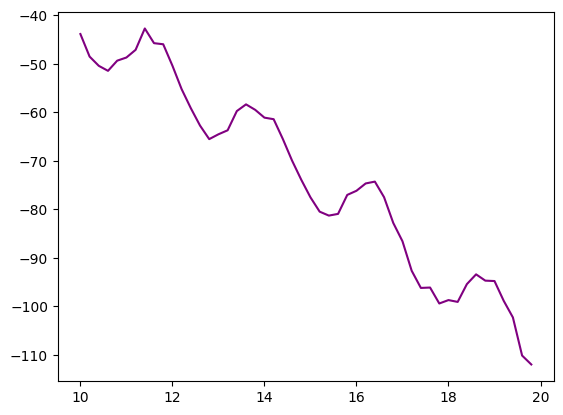

In [ ]:
plt.plot(x, -y, c = 'purple')
plt.show()

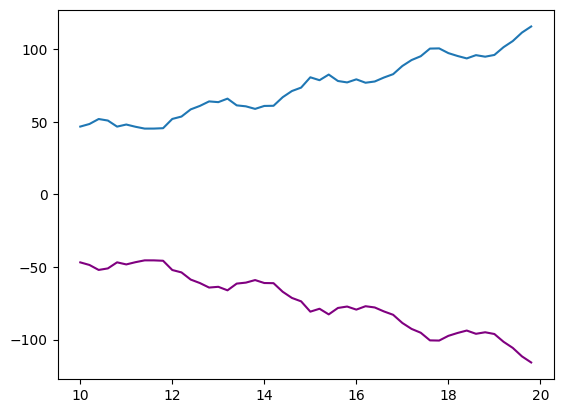

In [40]:
plt.plot(x, y)
plt.plot(x, -y, c = 'purple')
plt.show()

In [97]:
ideal = {
  'Price' : 1, # minimize
  'Milage' : 1, # also minimize
  'FuelEfficiency' : -1, # maximize (minimize the negative)
  'Emissions' : 1, # minimize again
  'Rating' : -1, # maximize
  'NPrice' : 1, # minimize
  'NMilage' : 1, # also minimize
  'NFuelEfficiency' : -1, # maximize (minimize the negative)
  'NEmissions' : 1, # minimize again
  'NRating' : -1 # maximize
}

multipliers = [ ideal[c] for c in cars.columns ]
multipliers

[1, 1, -1, 1, -1, 1, 1, -1, 1, -1]

In [84]:
def dominates(challenger, challenged): # smaller is better
  if all(v <= w for v, w in zip(challenger, challenged)): # if all aspects are at least as good
    return any( v < w for v, w in zip(challenger, challenged)) # and at least one is actually better
  return False


x = [ 1, 2, 3 ]
y = [ 0, 1, 2 ]
z = [ 1, 4, 3 ]

print('x vs. y', dominates(x, y))
print('y vs. x', dominates(y, x))
print('x vs. z', dominates(x, z))
print('z vs. x', dominates(z, x))
print('z vs. y', dominates(z, y))
print('y vs. z', dominates(y, z))

x vs. y False
y vs. x True
x vs. z True
z vs. x False
z vs. y False
y vs. z True


In [98]:
nondominated = set()

for i, data in cars.iterrows():
  car = [ m * v for m, v in zip(multipliers, data) ]
  discard = False # assume it to be invincible
  for j in range(i + 1, n): # check all the other cars
    otherData = cars.iloc[j] # get their data
    alt = [ m * v for m, v in zip(multipliers, otherData) ]
    if dominates(alt, car): # challenge the car with the alternative
      discard = True # we will not want to consider the loser
      break # no need to check further, it was already beaten
  if not discard: # nothing beat it
    nondominated.add(i) # remember the row

len(nondominated)

86

In [99]:
keep = sorted(list(nondominated))
candidates = cars.iloc[keep]
candidates

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
4,26446,18846,65,8215,5,0.725137,0.119448,0.875,0.215,1.00
6,28632,46113,55,8299,5,0.795379,0.304840,0.625,0.299,1.00
11,28570,24362,53,8079,5,0.793387,0.156952,0.575,0.079,1.00
18,21762,21169,48,8622,5,0.574628,0.135242,0.450,0.622,1.00
21,10608,138765,64,8019,2,0.216221,0.934796,0.850,0.019,0.25
...,...,...,...,...,...,...,...,...,...,...
195,35000,71090,43,8665,4,1.000000,0.474663,0.325,0.665,0.75
196,11792,125170,63,8905,2,0.254266,0.842361,0.825,0.905,0.25
197,9507,142239,64,8658,1,0.180843,0.958416,0.850,0.658,0.00
198,20526,79323,63,8814,5,0.534912,0.530640,0.825,0.814,1.00


In [100]:
candidates.loc[candidates['Price'].idxmin()]

Price               3879.000000
Milage             71865.000000
FuelEfficiency        63.000000
Emissions           8100.000000
Rating                 5.000000
NPrice                 0.000000
NMilage                0.479932
NFuelEfficiency        0.825000
NEmissions             0.100000
NRating                1.000000
Name: 76, dtype: float64

In [101]:
candidates.loc[candidates['Price'].idxmax()]

Price              35000.000000
Milage             71090.000000
FuelEfficiency        43.000000
Emissions           8665.000000
Rating                 4.000000
NPrice                 1.000000
NMilage                0.474663
NFuelEfficiency        0.325000
NEmissions             0.665000
NRating                0.750000
Name: 195, dtype: float64

In [102]:
budget = 12000
stars = 3
consider = candidates[ (candidates['Rating'] >= stars) & (candidates['Price'] <= budget) ]
consider

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
35,8907,53281,61,8130,3,0.161563,0.353577,0.775,0.130,0.50
40,4628,7303,38,8037,4,0.024067,0.040965,0.200,0.037,0.75
56,8256,46034,68,8430,3,0.140645,0.304303,0.950,0.430,0.50
64,10639,13806,47,8347,4,0.217217,0.085180,0.425,0.347,0.75
65,10273,37638,55,8541,5,0.205456,0.247217,0.625,0.541,1.00
76,3879,71865,63,8100,5,0.000000,0.479932,0.825,0.100,1.00
92,10643,131121,49,8050,4,0.217345,0.882823,0.475,0.050,0.75
107,9322,22100,54,8689,5,0.174898,0.141572,0.600,0.689,1.00
109,11292,4233,52,8567,4,0.238199,0.020092,0.550,0.567,0.75
112,10720,58895,39,8839,5,0.219819,0.391747,0.225,0.839,1.00


In [127]:
importance = { 'NMilage': 0.30, 'NFuelEfficiency': 0.30, 'NEmissions': 0.15, 'NRating': 0.1, 'NPrice': 0.15 }
sum(importance.values())

1.0

In [128]:
attr = ideal.keys()
factor = [ importance.get(a, 0) * ideal[a] for a in attr ] # all of the other columns will have zero weight
factor

[0, 0, 0, 0, 0, 0.15, 0.3, -0.3, 0.15, -0.1]

In [129]:
compromise = []
for i, data in consider.iterrows():
  combo = sum( [ f * d for f, d in zip(factor, data) ])
  compromise.append(combo)

cand = consider.copy()
l = 'Combination'
cand[l] = compromise
sorted = cand.sort_values(by = [l])
sorted.head(10) # top ten in terms of the lowest (best) combination score

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating,Combination
76,3879,71865,63,8100,5,0.000000,0.479932,0.825,0.100,1.00,-0.188520
124,4081,86341,69,8132,4,0.006491,0.578357,0.975,0.132,0.75,-0.173219
56,8256,46034,68,8430,3,0.140645,0.304303,0.950,0.430,0.50,-0.158112
35,8907,53281,61,8130,3,0.161563,0.353577,0.775,0.130,0.50,-0.132693
139,4139,60986,68,8567,3,0.008354,0.405964,0.950,0.567,0.50,-0.126908
183,6696,16531,54,8438,3,0.090518,0.103708,0.600,0.438,0.50,-0.119610
158,5399,75717,63,8464,5,0.048842,0.506123,0.825,0.464,1.00,-0.118737
40,4628,7303,38,8037,4,0.024067,0.040965,0.200,0.037,0.75,-0.113550
109,11292,4233,52,8567,4,0.238199,0.020092,0.550,0.567,0.75,-0.113193
107,9322,22100,54,8689,5,0.174898,0.141572,0.600,0.689,1.00,-0.107944


In [130]:
vars = ['Milage', 'FuelEfficiency', 'Emissions']
threedim = cand[vars]
threedim.head()

,Milage,FuelEfficiency,Emissions
35,53281,61,8130
40,7303,38,8037
56,46034,68,8430
64,13806,47,8347
65,37638,55,8541


In [131]:
import numpy as np

idx = threedim.index
cols = threedim.columns
matrix = np.array([ [ threedim[c][i] for c in cols ] for i in idx ])
print(matrix[:5])

[[53281    61  8130]
 [ 7303    38  8037]
 [46034    68  8430]
 [13806    47  8347]
 [37638    55  8541]]


In [132]:
x = matrix[:, 0]
y = matrix[:, 1]
z = matrix[:, 2]

x[:5]

array([53281,  7303, 46034, 13806, 37638])

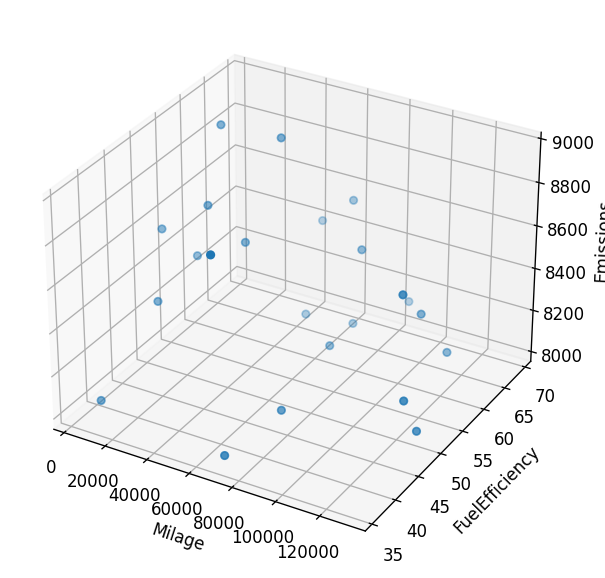

In [133]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize = (8, 6), dpi =  120)
a = fig.add_subplot(projection = '3d')
a.scatter(x, y, z, marker = 'o')
a.set_xlabel(vars[0])
a.set_ylabel(vars[1])
a.set_zlabel(vars[2])
plt.show()

In [134]:
stars = dict()
for quantity in [3, 4, 5]: # we already filtered out 1 and 2
  stars[quantity] = cand.loc[ cand['Rating'] == quantity ]

marker = {
  5 : '*', # use a star for 5
  4 : 'P', # use a thick plus for 4
  3 : 'd' # use a thin diamond for 3
}

for q in stars:
  print(q, len(stars[q]), marker[q])

3 8 d
4 7 P
5 8 *


In [135]:
data = dict()

for q in stars:
  subset = cand.loc[ cand['Rating'] == q ] # match the stars
  td = subset[vars] # get the three axis values
  M = np.array([ [ td[c][i] for c in td.columns ] for i in td.index ])
  color = subset['Price'].tolist()
  data[q] = (M, color)

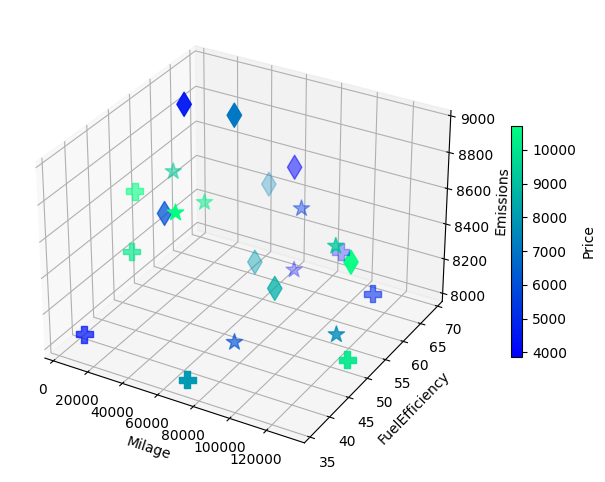

In [136]:
fig = plt.figure(1, figsize = (10, 6), dpi =  100)
a = fig.add_subplot(projection = '3d')
for q in stars:
  m, color = data[q]
  x = m[:, 0]
  y = m[:, 1]
  z = m[:, 2]
  plot = a.scatter(x, y, z, marker = marker[q], c = color, cmap = plt.cm.winter, s = 150)
a.set_xlabel(vars[0])
a.set_ylabel(vars[1])
a.set_zlabel(vars[2])
legend = fig.colorbar(plot, orientation = 'vertical', shrink = 0.5)
legend.set_label('Price')
plt.show()

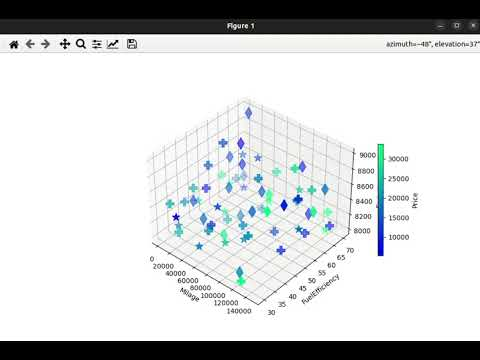

In [137]:
from IPython.display import YouTubeVideo
YouTubeVideo('c-vNm6lgeRQ')